<a href="https://www.kaggle.com/code/akscent/review-classifer-best-baseline?scriptVersionId=148752594" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%load_ext autoreload
%autoreload 2
!pip install pymorphy2 cleantext -U nlp_profiler

  Using cached nlp_profiler-0.0.3-py2.py3-none-any.whl (49 kB)
  Using cached tqdm-4.46.0-py2.py3-none-any.whl (63 kB)
  Using cached spacy-2.3.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
  Using cached textstat-0.7.3-py3-none-any.whl (105 kB)
  Using cached thinc-7.4.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached wasabi-0.10.1-py3-none-any.whl (26 kB)
  Using cached srsly-1.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (369 kB)
  Using cached catalogue-1.0.2-py2.py3-none-any.whl (16 kB)
  Using cached plac-1.1.3-py2.py3-none-any.whl (20 kB)
  Using cached pyphen-0.14.0-py3-none-any.whl (2.0 MB)
INFO: pip is looking at multiple versions of en-core-web-sm to determine which version is compatible with other requirements. This could take a while.


In [2]:
# # идея суммирования текста в более короткий текст


# from transformers import MBartTokenizer, MBartForConditionalGeneration

# model_name = "IlyaGusev/mbart_ru_sum_gazeta"
# tokenizer = MBartTokenizer.from_pretrained(model_name)
# model = MBartForConditionalGeneration.from_pretrained(model_name)

# def summary_rows(article_text):
#     input_ids = tokenizer(
#         [article_text],
#         max_length=500,
#         padding="max_length",
#         truncation=True,
#         return_tensors="pt",
#     )["input_ids"]

#     output_ids = model.generate(
#         input_ids=input_ids,
#         no_repeat_ngram_size=4
#     )[0]

#     summary = tokenizer.decode(output_ids, skip_special_tokens=True)
#     return summary

# def text_summary(text):
#     if isinstance(text, str) and text.strip() and len(str(text).split()) > 80:
#         return summary_rows(text)
#     else:
#         return text
    

# train_data['summary'] = train_data['text'].progress_apply(text_summary)


In [14]:
# добавление переменных о чувствах
from transformers import BertTokenizer, BertForSequenceClassification
model_name = 'Skoltech/russian-sensitive-topics'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name);
tokenized = tokenizer.batch_encode_plus(train_data[train_data["num_words"] > 80]['text'][370],max_length = 512,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False)
tokens_ids,mask = torch.tensor(tokenized['input_ids']),torch.tensor(tokenized['attention_mask']) 
with torch.no_grad():
    model_output = model(tokens_ids,mask)

def adjust_multilabel(y, is_pred = False):
    y_adjusted = []
    for y_c in y:
        y_test_curr = [0]*19
        index = str(int(np.argmax(y_c)))
        y_c = target_vaiables_id2topic_dict[index]
    return y_c

model_output

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


KeyboardInterrupt: 

In [17]:
# тональность текста
from transformers import pipeline
model = pipeline(model="seara/rubert-tiny2-russian-sentiment")
model(train_data[train_data["num_words"] > 80]['text'][48421])


[{'label': 'negative', 'score': 0.7839164733886719}]

In [18]:
# токичность
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
model = BertForSequenceClassification.from_pretrained('SkolkovoInstitute/russian_toxicity_classifier')
batch = tokenizer.encode(train_data[train_data["num_words"] > 80]['text'][48421], return_tensors='pt')
model(batch)


SequenceClassifierOutput(loss=None, logits=tensor([[ 2.6210, -1.9353]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [24]:
# эмоции
import torch
from transformers import BertForSequenceClassification, AutoTokenizer

LABELS = ['neutral', 'happiness', 'sadness', 'enthusiasm', 'fear', 'anger', 'disgust']
tokenizer = AutoTokenizer.from_pretrained('Aniemore/rubert-tiny2-russian-emotion-detection')
model = BertForSequenceClassification.from_pretrained('Aniemore/rubert-tiny2-russian-emotion-detection')

@torch.no_grad()
def predict_emotion(text: str) -> str:
    """
        We take the input text, tokenize it, pass it through the model, and then return the predicted label
        :param text: The text to be classified
        :type text: str
        :return: The predicted emotion
    """
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).numpy()
        
    return LABELS[predicted[0]]

@torch.no_grad()    
def predict_emotions(text: str) -> list:
    """
        It takes a string of text, tokenizes it, feeds it to the model, and returns a dictionary of emotions and their
        probabilities
        :param text: The text you want to classify
        :type text: str
        :return: A dictionary of emotions and their probabilities.
    """
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    emotions_list = {}
    for i in range(len(predicted.numpy()[0].tolist())):
        emotions_list[LABELS[i]] = predicted.numpy()[0].tolist()[i]
    return emotions_list

simple_prediction = predict_emotion(train_data[train_data["num_words"] > 80]['text'][48421])
not_simple_prediction = predict_emotions(train_data[train_data["num_words"] > 80]['text'][48421])

print(simple_prediction)
print(not_simple_prediction)

anger
{'neutral': 0.020537199452519417, 'happiness': 0.0474267415702343, 'sadness': 0.006376450881361961, 'enthusiasm': 0.02256331592798233, 'fear': 0.01204968523234129, 'anger': 0.8827062249183655, 'disgust': 0.008340339176356792}


In [ ]:
# textblob - обработка текста, генерация фич https://textblob.readthedocs.io/en/dev/quickstart.html
# еще одна библиотека для классификации текстов https://small-text.readthedocs.io/en/latest/
# полярность слов https://polyglot.readthedocs.io/en/latest/
# обработка фич https://github.com/jbesomi/texthero
# фичегенерация https://github.com/neomatrix369/nlp_profiler#Notebooks
# классификация на других предобученных моделях, перечисленных у Алерона https://github.com/a-milenkin/Competitive_Data_Science/blob/main/notebooks/9.2.1%20-%20Text_Embeddings.ipynb
# использовать эти ноутбуки для классификации https://github.com/e0xextazy/vkcup2022-first-stage/blob/main/inference.ipynb

In [407]:
train_data["num_words"] = train_data["text"].apply(
    lambda x: len(str(x).split()))
test_data["num_words"] = test_data["text"].apply(
    lambda x: len(str(x).split()))

In [22]:
train_data[train_data["num_words"] > 80]['text']

370      каждый день хлебо булко жидкость дпосудыбывало...
1106     замечательный магазин ремонта стал ещё краше п...
1482     здравствуйте сегодня хочу поделиться своим мне...
2055     пятерочкидо ремонта этим летом ремонта этим ле...
2167     магазин целом неплохойместа многоне приходится...
                               ...                        
47432    поставить меньше поставила задумываясь зашла в...
47632    давние сотрудники стараются могут директора ме...
48064    ценники часто забывают менять тараканытоваров ...
48253    достаточно хороший ассортимент товара магазина...
48421    здравствуйте мая года районе конце прогулки за...
Name: text, Length: 251, dtype: object

# Import Libraries

In [4]:
import os
import sys
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

sys.path.insert(1, '/kaggle/input/ods-huawei/nlp_huawei_new2_task-master/nlp_huawei_new2_task-master/baseline_transformers')
# from dataset import *
# from model import *
# from trainer import Trainer

import torch
from torch.utils.data import Dataset
from typing import Dict
import json
from numpy import asarray
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW
from tqdm.notebook import tqdm

torch.manual_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# CLasses

In [25]:
class FiveDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_seq_len):
        self.data = dataframe
        self.text = dataframe['text'].tolist()
        self.targets = None
        if 'rate' in dataframe:
            self.targets = dataframe['rate'].tolist()
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_seq_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if self.targets is not None:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'targets': torch.tensor(self.targets[index], dtype=torch.long)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
            }

    def __len__(self) -> int:
        return len(self.text)
    

class ModelForClassification(torch.nn.Module):

    def __init__(self, model_path: str, config: Dict):
        super(ModelForClassification, self).__init__()
        self.model_name = model_path
        self.config = config
        self.n_classes = config['num_classes']
        self.dropout_rate = config['dropout_rate']
        self.bert = AutoModel.from_pretrained(self.model_name)
        self.pre_classifier = torch.nn.Linear(312, 768)
        self.dropout = torch.nn.Dropout(self.dropout_rate)
        self.classifier = torch.nn.Linear(768, self.n_classes)
        self.softmax = torch.nn.LogSoftmax(dim = 1)

    def forward(self, input_ids, attention_mask,):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        hidden_state = output[0]
        hidden_state = hidden_state[:, 0]
        hidden_state = self.pre_classifier(hidden_state)
        hidden_state = torch.nn.ReLU()(hidden_state)
        hidden_state = self.dropout(hidden_state)
        output = self.classifier(hidden_state)
        output = self.softmax(output)
        return output


class Trainer:
    def __init__(self, config: Dict, class_weights=None):
        self.config = config
        self.device = config['device']
        self.n_epochs = config['n_epochs']
        self.optimizer = None
        self.opt_fn = lambda model: AdamW(model.parameters(), config['lr'])
        self.model = None
        self.history = None
        if class_weights is not None:
            class_weights = class_weights.to(self.device)
            self.loss_fn = CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = CrossEntropyLoss()
        self.device = config['device']
        self.verbose = config.get('verbose', True)
        
    def save_history(self, path: str):
        history = {
            'train_loss': self.history['train_loss'],
            'val_loss': self.history['val_loss'],
            'val_acc': self.history['val_acc']
        }
        val_acc = sum(self.history['val_acc']) / len(self.history['val_acc'])
        print("All ACCURACY = ", val_acc)
        with open(path, 'w') as file:
            json.dump(history, file)
        
    def load_history(self, path: str):
        with open(path, 'r') as file:
            history = json.load(file)
        self.history = {
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'val_acc': history['val_acc']
        }

    def fit(self, model, train_dataloader, val_dataloader):
        self.model = model.to(self.device)
        self.optimizer = self.opt_fn(model)
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': []
        }
        best_val_loss = float('inf')

        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}/{self.n_epochs}")
            train_info = self.train_epoch(train_dataloader)
            val_info = self.val_epoch(val_dataloader)
            self.history['train_loss'].extend(train_info['loss'])
            self.history['val_loss'].extend([val_info['loss']])
            self.history['val_acc'].extend([val_info['acc']])

            if val_info['loss'] < best_val_loss:
                best_val_loss = val_info['loss']
                self.save_model_weights('best_model_weights.ckpt')

            self.save_history('history.json')

        return self.model.eval()

    def save_model_weights(self, path: str):
        torch.save(self.model.state_dict(), path)



    def train_epoch(self, train_dataloader):
        self.model.train()
        losses = []
        total_loss = 0
        if self.verbose:
            train_dataloader = tqdm(train_dataloader)
        for batch in train_dataloader:
            ids = batch['ids'].to(self.device, dtype=torch.long)
            mask = batch['mask'].to(self.device, dtype=torch.long)
            targets = batch['targets'].to(self.device, dtype=torch.long)

            outputs = self.model(ids, mask)
            loss = self.loss_fn(outputs, targets)
            total_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_val = loss.item()
            if self.verbose:
                train_dataloader.set_description(f"Loss={loss_val:.3}")
            losses.append(loss_val)
        avg_loss = total_loss / len(train_dataloader)
        print("AVG LOSS = ", avg_loss)
        return {'loss': losses}

    def val_epoch(self, val_dataloader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_dataloader = tqdm(val_dataloader)
        with torch.no_grad():
            for batch in val_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                targets = batch['targets'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                all_logits.append(outputs)
                all_labels.append(targets)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits).to(self.device)
        loss = self.loss_fn(all_logits, all_labels).item()
        acc = (all_logits.argmax(1) == all_labels).float().mean().item()
        print("ACCURACY for EPOCH = ", acc)
        if self.verbose:
            val_dataloader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
        return {
            'acc': acc,
            'loss': loss
        }

    def predict(self, test_dataloader):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_dataloader:
                ids = batch['ids'].to(self.device, dtype=torch.long)
                mask = batch['mask'].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask)
                preds = torch.exp(outputs)
                predictions.extend(preds.tolist())
        return asarray(predictions)

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "config": self.model.config,
            "trainer_config": self.config,
            "model_name": self.model.model_name,
            "model_state_dict": self.model.state_dict()
        }
        torch.save(checkpoint, path)

    def plot_history(self):
        import matplotlib.pyplot as plt
        
        if self.history is None:
            raise RuntimeError("History is not available. Train the model first.")

        train_loss = self.history['train_loss']
        val_loss = self.history['val_loss']
        val_acc = self.history['val_acc']

        epochs = range(1, len(train_loss) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()


    @classmethod
    def load(cls, path: str):
        ckpt = torch.load(path)
        keys = ["config", "trainer_config", "model_state_dict"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = ModelForClassification(
            ckpt['model_name'],
            ckpt["config"]
        )
        new_model.load_state_dict(ckpt["model_state_dict"])
        new_trainer = cls(ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer

In [26]:
PATH = "/kaggle/input/ods-huawei/"
MAX_LEN = 50
BATCH_SIZE = 64

# Loading data

In [95]:
train_data = pd.read_csv(os.path.join(PATH, "train.csv"))
test_data = pd.read_csv(os.path.join(PATH, "test.csv"))

train_data.head()

,rate,text
0,4,Очень понравилось. Были в начале марта с соба...
1,5,В целом магазин устраивает.\nАссортимент позво...
2,5,"Очень хорошо что открылась 5 ка, теперь не над..."
3,3,Пятёрочка громко объявила о том как она заботи...
4,3,"Тесно, вечная сутолока, между рядами трудно ра..."


# Label encoding

In [96]:
le = LabelEncoder()

train_data.rate = le.fit_transform(train_data.rate)
train_data.head()

,rate,text
0,3,Очень понравилось. Были в начале марта с соба...
1,4,В целом магазин устраивает.\nАссортимент позво...
2,4,"Очень хорошо что открылась 5 ка, теперь не над..."
3,2,Пятёрочка громко объявила о том как она заботи...
4,2,"Тесно, вечная сутолока, между рядами трудно ра..."


# Cleaning

In [98]:
%aimport nltk.corpus.reader.bracket_parse
%autoreload 0

import cleantext

def clean_text(text):
    return cleantext.clean(text,
                            clean_all= False, # Execute all cleaning operations
                            extra_spaces=True ,  # Remove extra white spaces 
#                             stemming=True , # Stem the words
#                             stopwords=True ,# Remove stop words
                            lowercase=True ,# Convert to lowercase
                            numbers=True ,# Remove all digits 
                            punct=True ,# Remove all punctuations
#                             reg: str = '<regex>', # Remove parts of text based on regex
#                             reg_replace: str = '<replace_value>', # String to replace the regex used in reg
                            stp_lang='russian',  # Language for stop words
                          )

def text_cleaning(text):
    if isinstance(text, str) and text.strip():
        return clean_text(text)
    else:
        return text

In [99]:
# import re
# from nltk.corpus import stopwords
# import pymorphy2

# TOKEN_RE = re.compile(r'[а-яё]+')
# russian_stopwords = set(stopwords.words("russian"))
# lemmatizer = pymorphy2.MorphAnalyzer()

# def tokenize_text(text, min_length_token=1):
#     text = text.lower()
#     tokens = TOKEN_RE.findall(text)
#     return [token for token in tokens if len(token) >= min_length_token]

# def remove_stopwords(tokens):
#     return [token for token in tokens if token not in russian_stopwords]

# def lemmatize(tokens):
#     return [lemmatizer.parse(token)[0].normal_form for token in tokens]

# def text_cleaning(text):
#     tokens = tokenize_text(text)
#     tokens = remove_stopwords(tokens)
#     tokens = lemmatize(tokens)
#     return ' '.join(tokens)

tqdm.pandas()
train_data['text'] = train_data['text'].progress_apply(text_cleaning)
test_data['text'] = test_data['text'].progress_apply(text_cleaning)

train_data["num_words"] = train_data["text"].apply(
    lambda x: len(str(x).split()))
test_data["num_words"] = test_data["text"].apply(
    lambda x: len(str(x).split()))



  0%|          | 0/48665 [00:00<?, ?it/s]

  0%|          | 0/12167 [00:00<?, ?it/s]

In [100]:
import plotly.express as px
def show_count_by_rate(data, rate_name = None, name = "Data"):
    fig = px.histogram(data, x="num_words", color=rate_name, title=f"Number of words in {name} by rate")
    fig.update_layout(bargap=0.2)

    fig.show()
    
show_count_by_rate(train_data, rate_name = "rate", name = 'Train_data')
show_count_by_rate(test_data, name = 'Test_data')

In [101]:
# удалим все 0 и те, чье количество меньше 30
train_data = train_data[train_data['num_words'] != 0]
# train_data = train_data[train_data['num_words'] < 30]

# Train Test split

In [102]:
# train_split, val_split = train_test_split(train_data[train_data['rate'] != 4], test_size=0.15, random_state=42, 
#                                           shuffle = True, stratify=train_data[train_data['rate'] != 4]['rate'])

train_split, val_split = train_test_split(train_data, test_size=0.15, random_state=42, 
                                          shuffle = True, stratify=train_data['rate'])

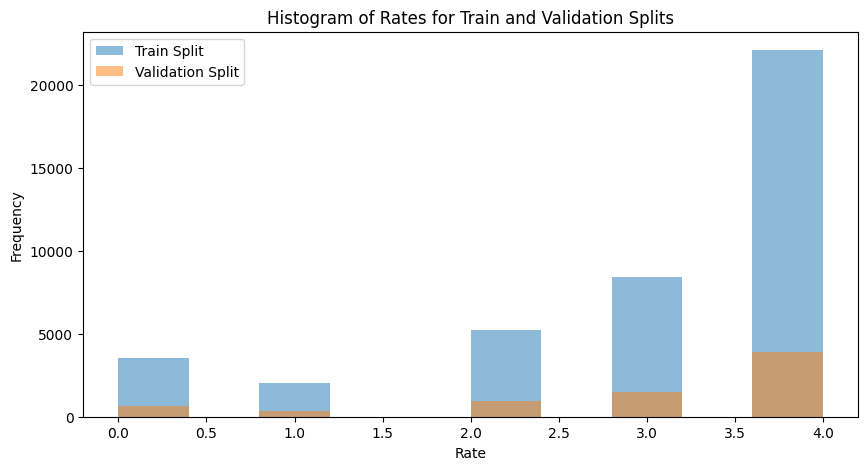

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(train_split['rate'], bins=10, alpha=0.5, label='Train Split')
plt.hist(val_split['rate'], bins=10, alpha=0.5, label='Validation Split')

plt.xlabel('Rate')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Rates for Train and Validation Splits')

plt.show()

In [104]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_split['rate']), y=train_split['rate'])
weight_tensor = torch.FloatTensor(weights)
print(weights)

[2.34660222 4.03372434 1.58589547 0.98063213 0.37374332]


# Loading tokenizer from pretrained

In [105]:
tokenizer = AutoTokenizer.from_pretrained(
    "cointegrated/rubert-tiny2", truncation=True, do_lower_case=True)

# Creating datasets and dataloaders

In [106]:
train_dataset = FiveDataset(train_split, tokenizer, MAX_LEN)
val_dataset = FiveDataset(val_split, tokenizer, MAX_LEN)
test_dataset = FiveDataset(test_data, tokenizer, MAX_LEN)

In [107]:
MAX_LEN = 100
BATCH_SIZE = 400

In [108]:
train_params = {"batch_size": BATCH_SIZE,
                "shuffle": True,
                "num_workers": 0
                }

test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 0
               }

train_dataloader = DataLoader(train_dataset, **train_params)
val_dataloader = DataLoader(val_dataset, **test_params)
test_dataloader = DataLoader(test_dataset, **test_params)

# Loading pretrained model from Huggingface

In [109]:
config = {
    "num_classes": len(np.unique(train_split['rate'])),
    "dropout_rate": 0.1
}
model = ModelForClassification(
    "cointegrated/rubert-tiny2",
    config=config
)

# Creating Trainer object and fitting the model

In [110]:
trainer_config = {
    "lr": 3e-4,
    "n_epochs": 3,
    "weight_decay": 1e-6,
    "batch_size": BATCH_SIZE,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42,
}
t = Trainer(trainer_config, class_weights=weight_tensor)
# ,class_weights=weight_tensor

In [111]:
t.fit(
    model,
    train_dataloader,
    val_dataloader
)

Epoch 1/3


  0%|          | 0/104 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



AVG LOSS =  1.2285906317142339


  0%|          | 0/19 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.576960027217865
All ACCURACY =  0.576960027217865
Epoch 2/3


  0%|          | 0/104 [00:00<?, ?it/s]

AVG LOSS =  1.0471249566628382


  0%|          | 0/19 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.5674859285354614
All ACCURACY =  0.5722229778766632
Epoch 3/3


  0%|          | 0/104 [00:00<?, ?it/s]

AVG LOSS =  0.8738164792840297


  0%|          | 0/19 [00:00<?, ?it/s]

ACCURACY for EPOCH =  0.594260573387146
All ACCURACY =  0.5795688430468241


ModelForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, element

# Save model

In [80]:
t.save("best_baseline_model.ckpt")

# Load pretrained Model

In [81]:
t = Trainer.load("best_baseline_model.ckpt")

# Get testset predictions


In [112]:
predictions = t.predict(test_dataloader)

In [113]:
predicted_classes = [np.argmax(probabilities) + 1 for probabilities in predictions]

# Create submission


In [114]:
sample_submission = pd.read_csv(os.path.join(PATH, "sample_submission.csv"))
sample_submission["rate"] = predicted_classes
# sample_submission.rate = le.inverse_transform(sample_submission.rate)
sample_submission.head()

,index,rate
0,0,5
1,1,3
2,2,5
3,3,3
4,4,2


In [115]:
sample_submission.to_csv("submission.csv", index=False)

# Train conf matrix

In [116]:
predictions_val = t.predict(val_dataloader)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [117]:
predicted_classes_val = [np.argmax(probabilities) + 1 for probabilities in predictions_val]

Classification Report for val dataset:
               precision    recall  f1-score   support

           1       0.54      0.53      0.54       627
           2       0.27      0.16      0.20       603
           3       0.42      0.36      0.39      1086
           4       0.42      0.40      0.41      1553
           5       0.74      0.84      0.79      3414

    accuracy                           0.59      7283
   macro avg       0.48      0.46      0.47      7283
weighted avg       0.57      0.59      0.58      7283



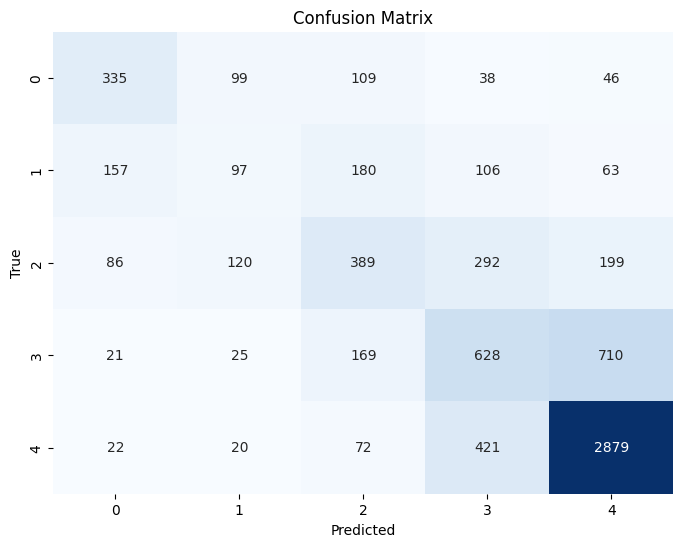

In [118]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_classification_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_classification_metrics(predicted_classes_val, le.inverse_transform(val_split['rate']), "val dataset")